# Activation stats

In [15]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [16]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [17]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [18]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

## Baseline

In [19]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1,   8, ks=5), # 14x14
        conv(8,  16),      # 7x7
        conv(16, 32),     # 4x4
        conv(32, 64),     # 2x2
        conv(64, 10, act=False),     # 1x1
        nn.Flatten()]

In [20]:
from torcheval.metrics import MulticlassAccuracy

In [21]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [22]:
# NB: high learning rate to iterate quickly but high potential for blowup/ issues
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.158,2.298,0,train
0.204,2.035,0,eval


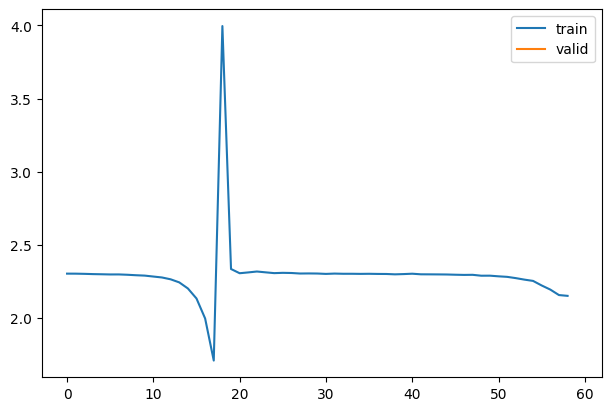

In [23]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))
# learn.fit(1)

## Hooks

### Manual insertion

In [30]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
    
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            x_cpu = to_cpu(x)
            self.act_means[i].append(x_cpu.mean())
            self.act_stds[i].append(x_cpu.std())
        return x
    
    def __iter__(self): return iter(self.layers)

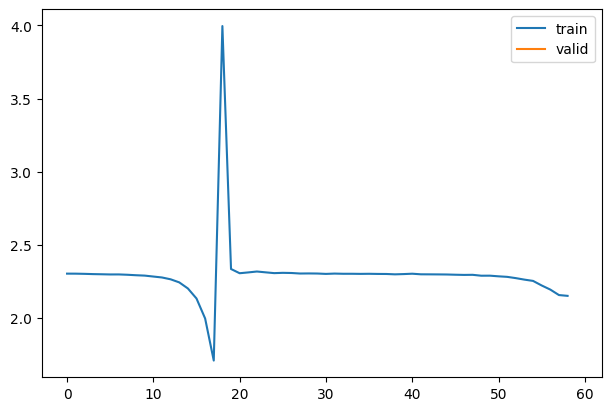

In [31]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

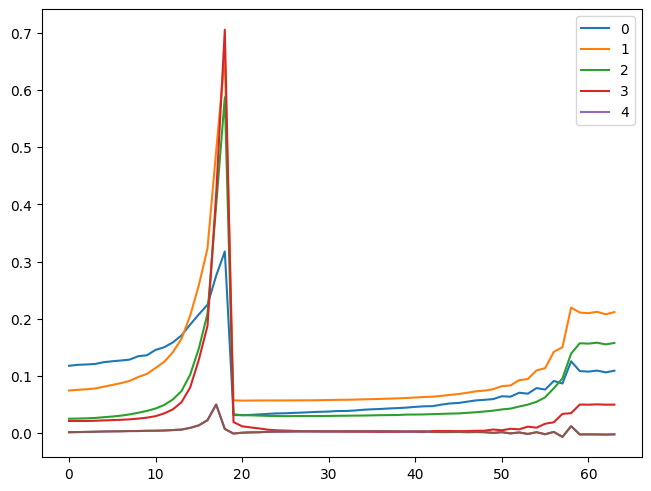

In [34]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

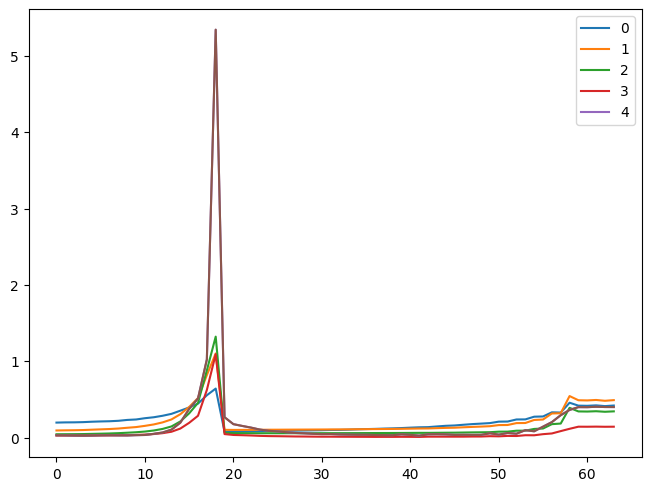

In [35]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### PyTorch hooks

Can register object to any nn.Module, called when a layer it's registered to is exceuted on forward or backward passes, depending on which hook type is registered

In [58]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [59]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [60]:
def append_stats(i, mod, inp, outp):
    outp_cpu = to_cpu(outp)
    act_means[i].append(outp_cpu.mean())
    act_stds[i].append(outp_cpu.std())

In [61]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.158,2.298,0,train
0.204,2.035,0,eval


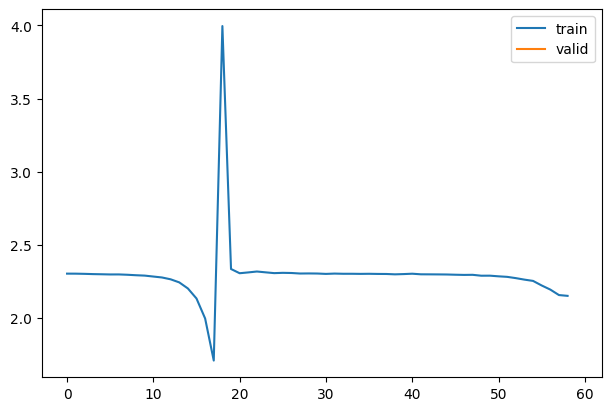

In [62]:
fit(model)

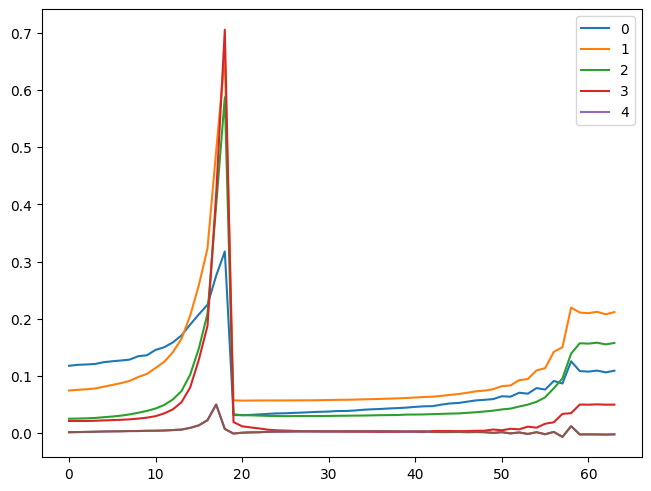

In [44]:
for o in act_means: plt.plot(o)
plt.legend(range(len(model)-1))

### Hook class

__Note__ the need to remove the hook when they're deleted, otherwise references will still exist and memory used by them will not be released when the model is deleted!